Dans ce script, nous allons tester différents modèles de type convolutionnelsur le dataset 

résultat:
* l'utilisation des batchs rend l'inférence globale plus rapide
* un modèle a besoin de beaucoup de temps / parametres pour arriver à un certain niveau d'accuracy

In [1]:
import retinoto_py as fovea
n_val_stop = 0
args = fovea.Params(n_val_stop=n_val_stop, in_memory=False)
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_21-47-49	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.


Params(image_size=224, do_mask=False, do_fovea=False, rs_min=0.0, rs_max=-6.0, padding_mode='zeros', seed=2018, batch_size=80, num_workers=1, in_memory=False, model_name='convnext_base', num_epochs=24, n_train_stop=20480, n_val_stop=0, lr=1e-06, delta1=0.1, delta2=0.007, weight_decay=0.03, label_smoothing=0.2, shuffle=True, verbose=True)

In [2]:
fovea.all_cn_model_names

['convnext_tiny', 'convnext_base', 'convnext_large']

# testing different networks

In [3]:
json_filename = args.data_cache / '14_model_cn_comparison.json'

# %rm {json_filename}  # FORCING RECOMPUTE

if json_filename.exists():
    results = fovea.pd.read_json(json_filename)
else:
    all_results = []
    for do_mask in [True, False]:
        for dataset in fovea.all_datasets:
            args = fovea.Params(do_mask=do_mask, n_val_stop=n_val_stop, in_memory=False)
            VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
            val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, n_stop=args.n_val_stop)
            val_loader = fovea.get_loader(args, val_dataset)
            for model_name in fovea.all_cn_model_names:
                args.do_mask = do_mask
                args.model_name = model_name
                model = fovea.load_model(args)
                param_stats = fovea.count_parameters(model)
                total_layers = fovea.count_layers(model)
                tic = fovea.time.time()
                accuracy = fovea.get_validation_accuracy(args, model, val_loader, f"Model {args.model_name}\t dataset: {dataset}\t(do_mask={do_mask})")            
                toc = fovea.time.time()
                this_result = { 'model_name': model_name,
                                'do_mask': do_mask,
                                'dataset': dataset,
                                'accuracy': accuracy,
                                'wall_clock_time': (toc-tic)/len(val_dataset),
                                'total_parameters': param_stats['total_parameters'],
                                'trainable_parameters': param_stats['trainable_parameters'],
                                'total_layers': total_layers}
                all_results.append(this_result)
    results = fovea.pd.DataFrame(all_results)
    results.to_json(json_filename, orient='records', indent=2)


In [4]:
results

,model_name,do_mask,dataset,accuracy,wall_clock_time,total_parameters,trainable_parameters,total_layers
0,convnext_tiny,True,full,0.805078,0.005055,28589128,28589128,203
1,convnext_base,True,full,0.824805,0.012205,88591464,88591464,383
2,convnext_large,True,full,0.833398,0.021718,197767336,197767336,383
3,convnext_tiny,True,bbox,0.742773,0.004498,28589128,28589128,203
4,convnext_base,True,bbox,0.760156,0.011987,88591464,88591464,383
5,convnext_large,True,bbox,0.774219,0.021599,197767336,197767336,383
6,convnext_tiny,False,full,0.815234,0.004768,28589128,28589128,203
7,convnext_base,False,full,0.831836,0.012164,88591464,88591464,383
8,convnext_large,False,full,0.840039,0.021757,197767336,197767336,383
9,convnext_tiny,False,bbox,0.757617,0.004506,28589128,28589128,203


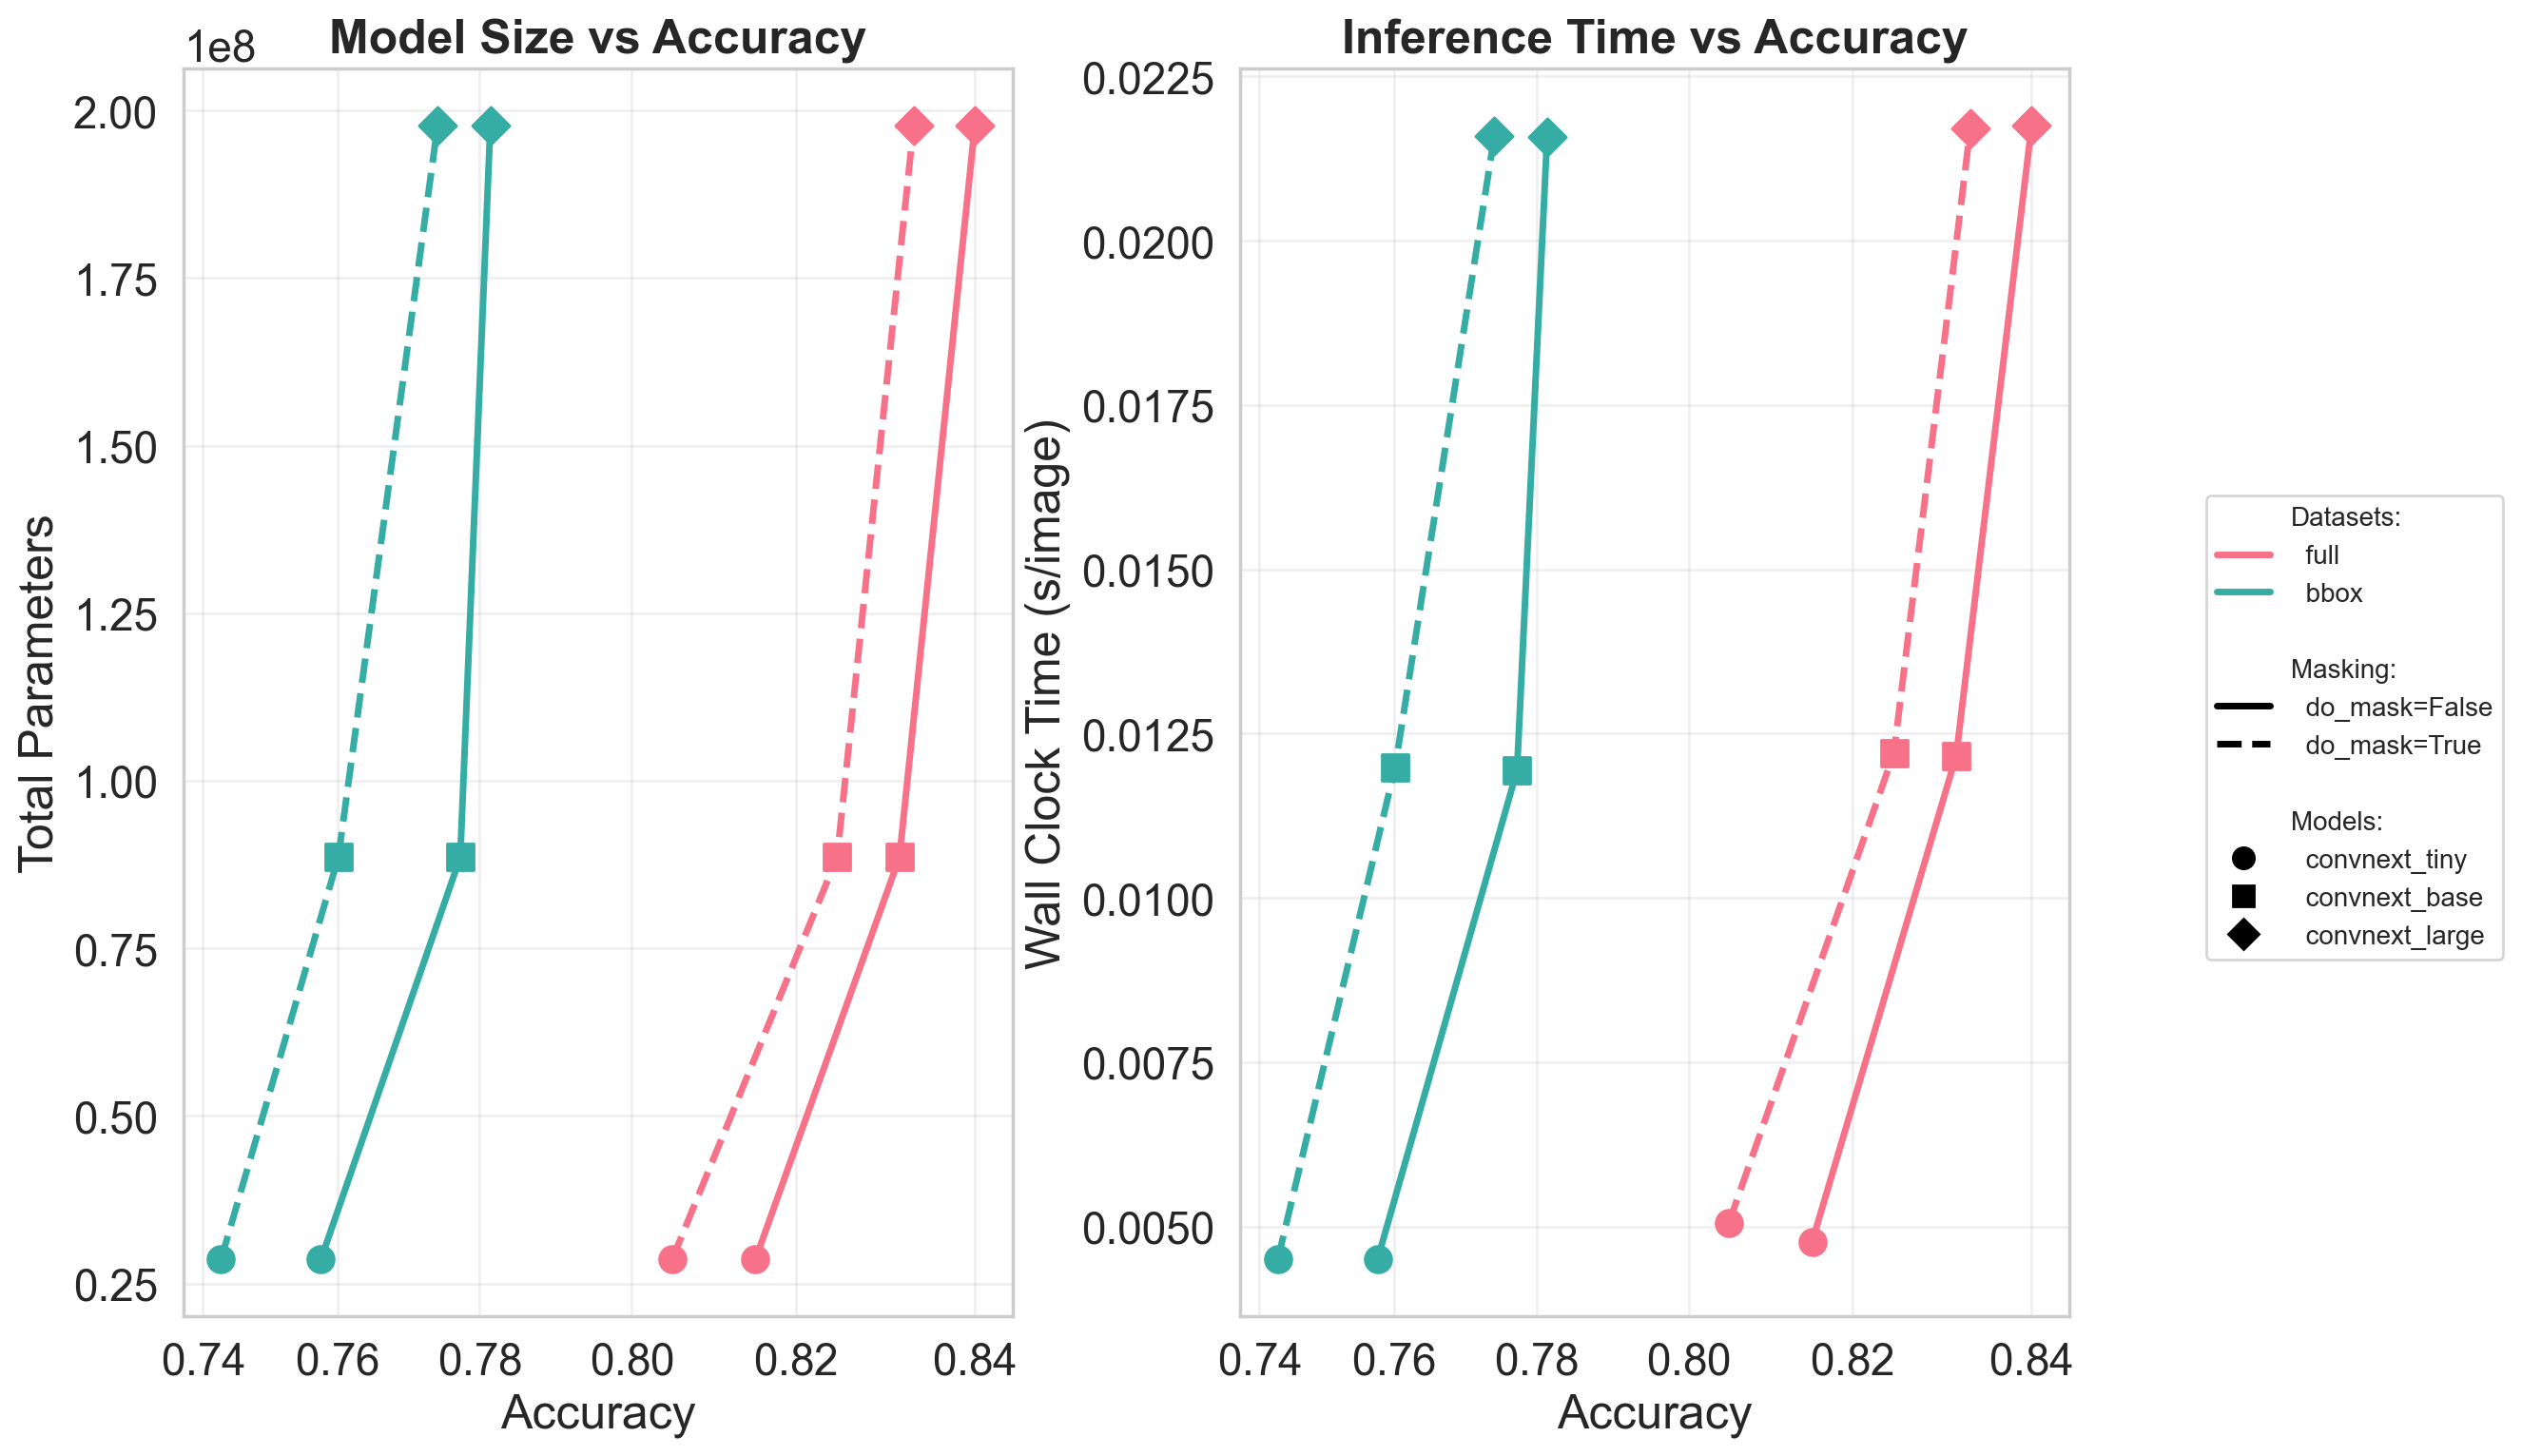

In [5]:
fig, axes = fovea.plot_model_comparison(results, fovea.all_cn_model_names, fovea.all_datasets, do_masks=[True, False], figures_folder=args.figures_folder, save_name='14_model_convnext', exts=['svg'])


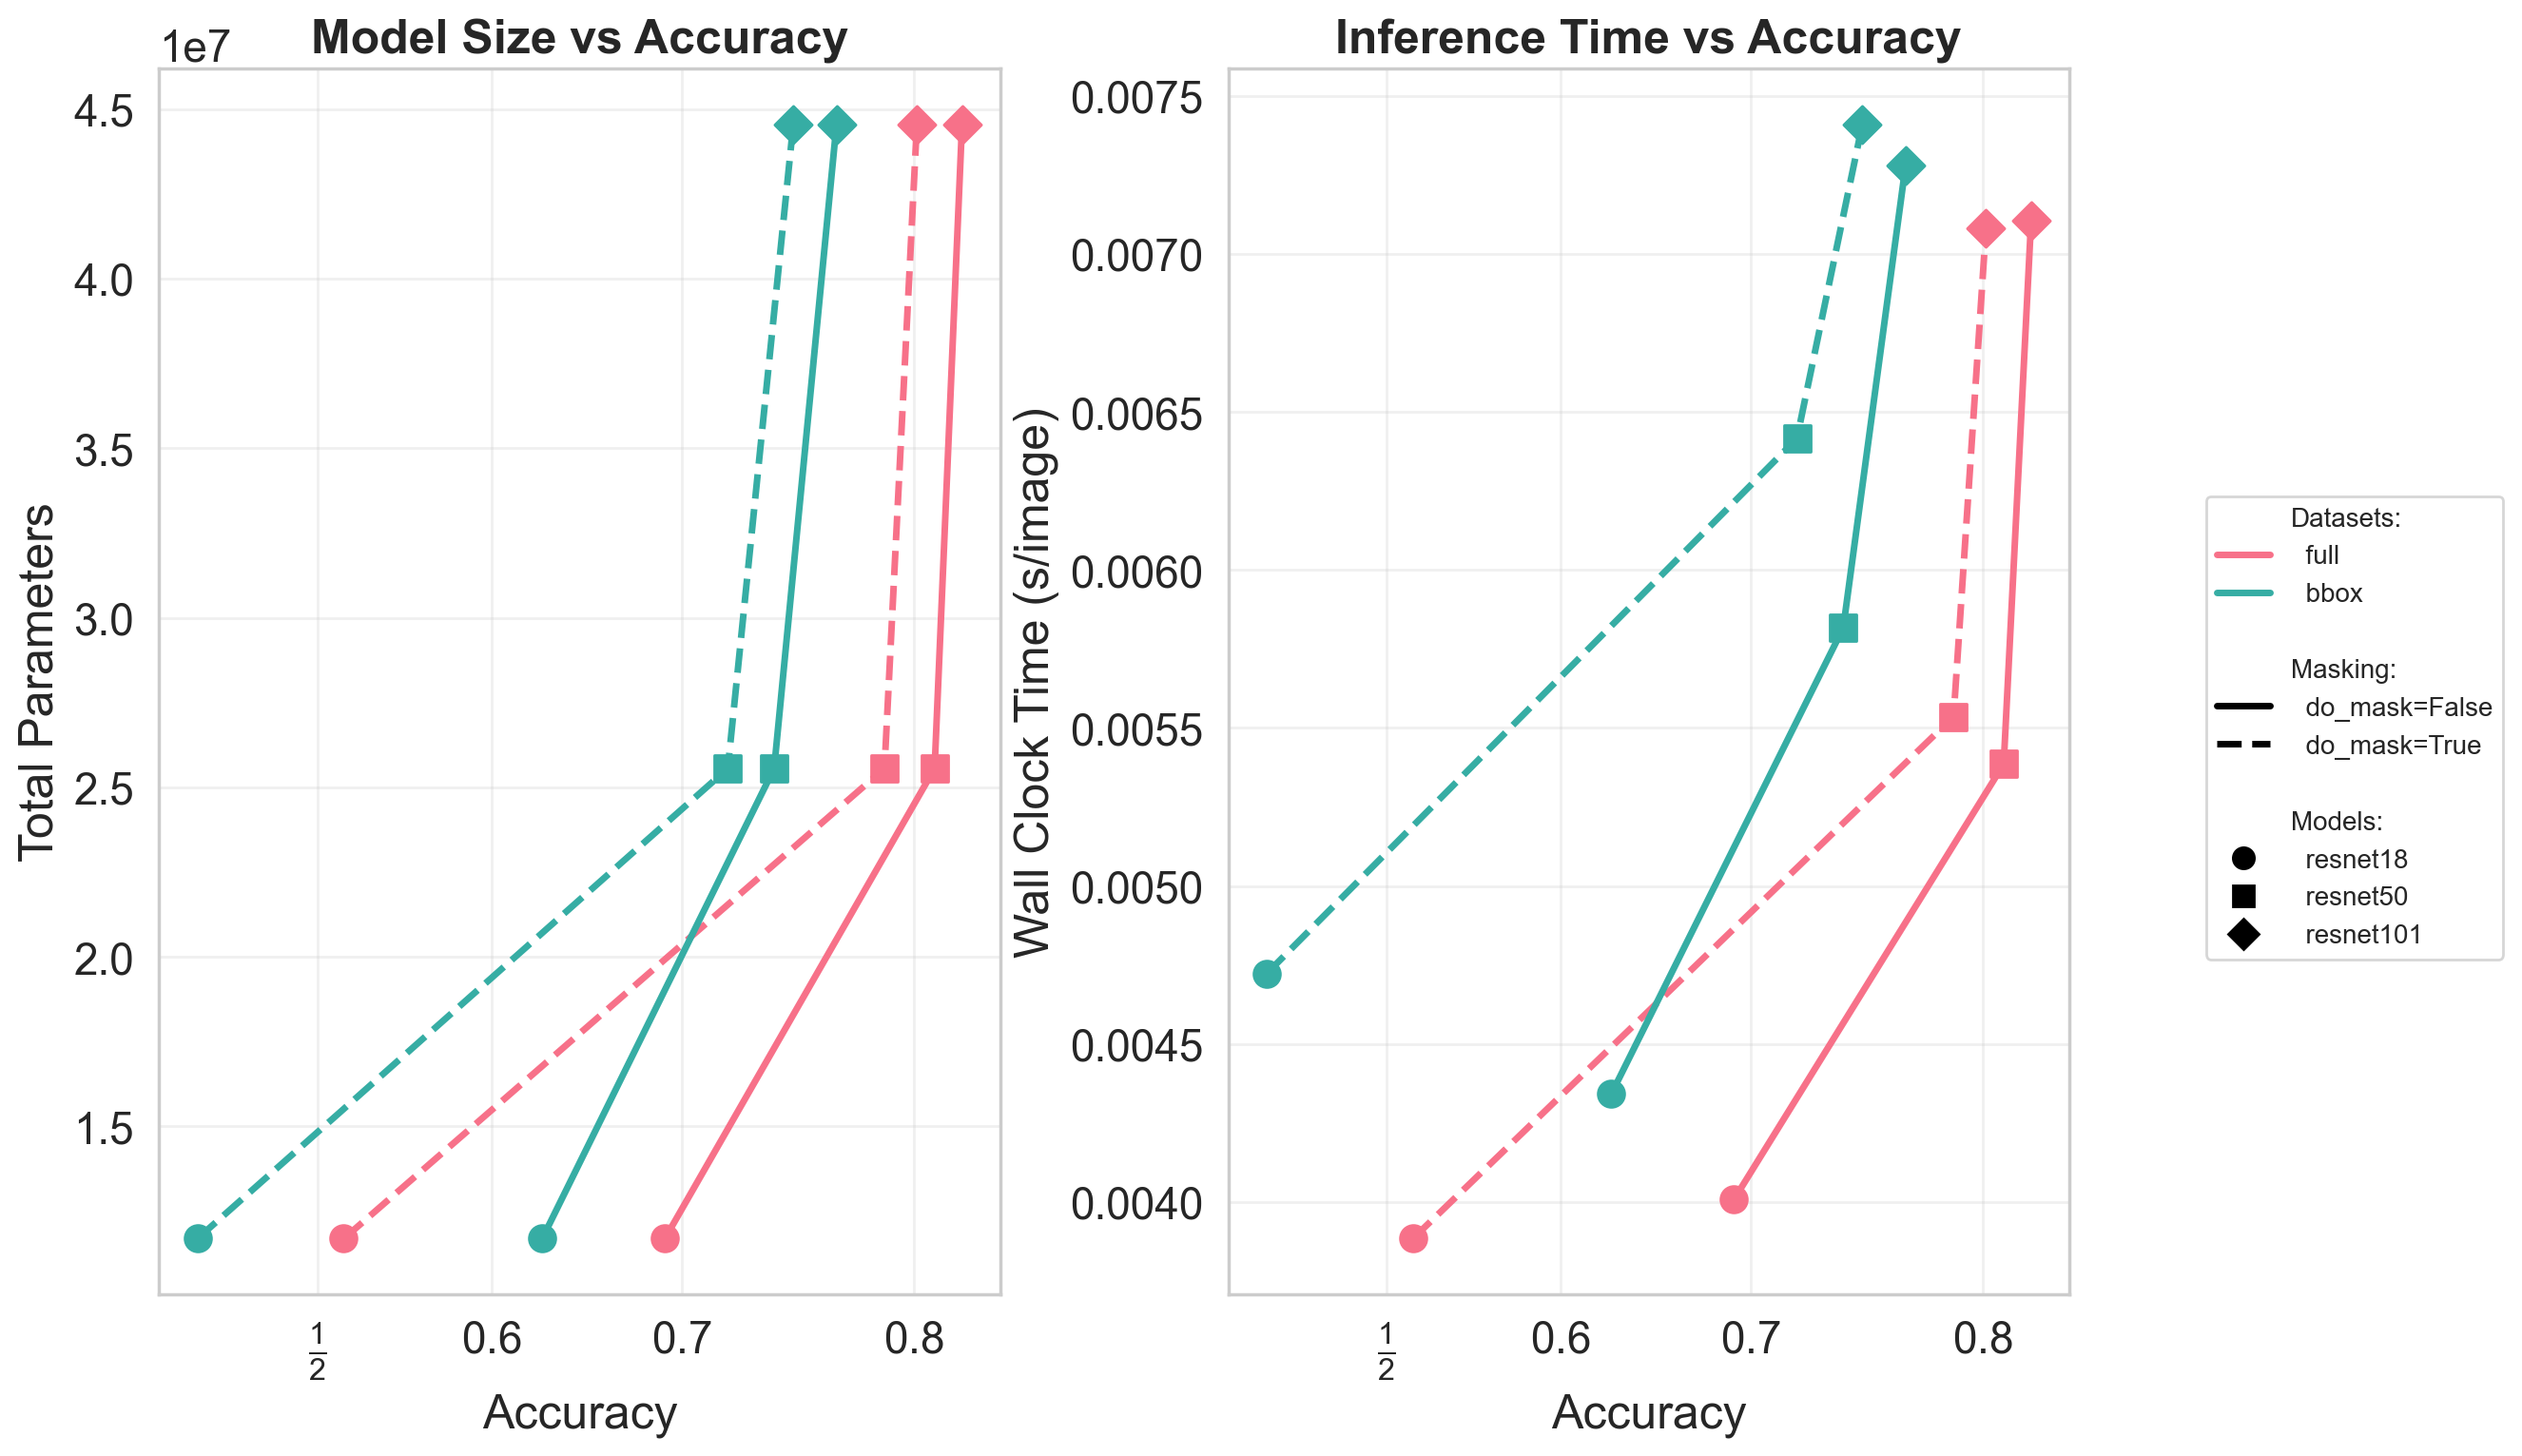

In [6]:
json_filename = args.data_cache / '13_model_comparison.json'
results = fovea.pd.read_json(json_filename)
fig, axes = fovea.plot_model_comparison(results, fovea.all_model_names, fovea.all_datasets, do_masks=[True, False], figures_folder=args.figures_folder)


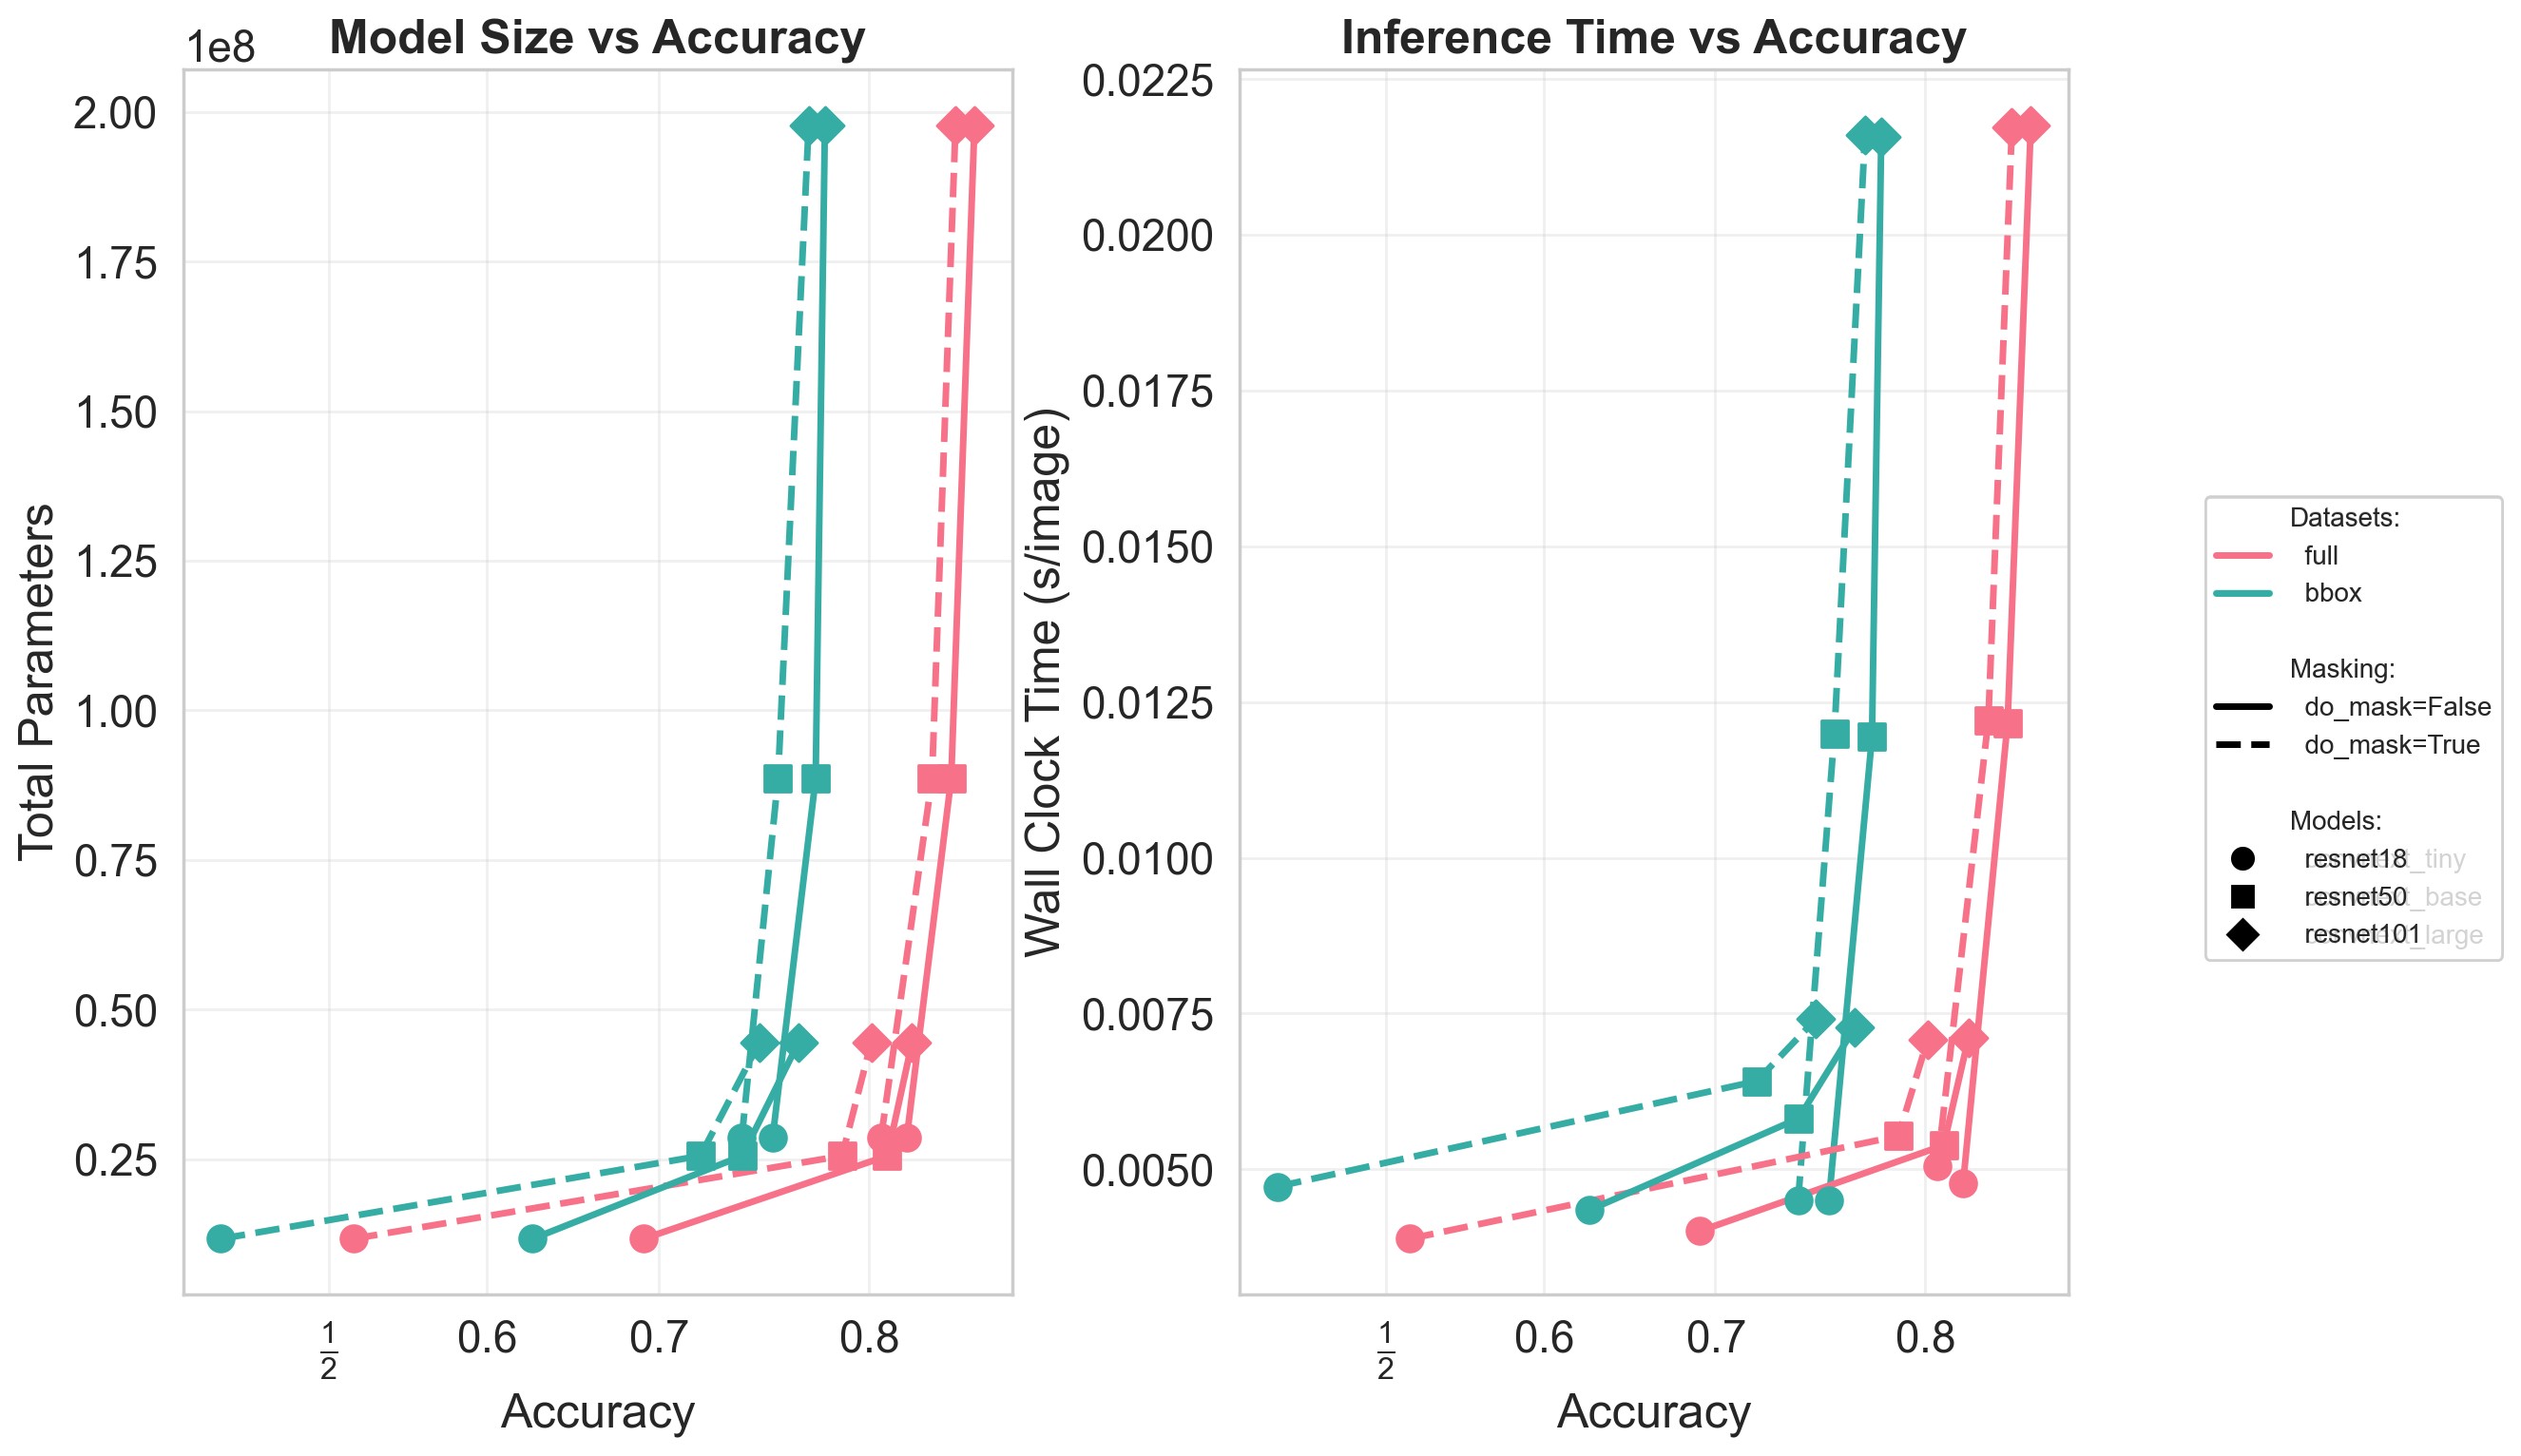

In [7]:
json_filename = args.data_cache / '14_model_cn_comparison.json'
results14 = fovea.pd.read_json(json_filename)

fig, axes = fovea.plot_model_comparison(results14, fovea.all_cn_model_names, fovea.all_datasets, do_masks=[True, False], figures_folder=args.figures_folder, save_name='14_model_convnext', exts=['svg'])

json_filename = args.data_cache / '13_model_comparison.json'
results13 = fovea.pd.read_json(json_filename)
fig, axes = fovea.plot_model_comparison(results13, fovea.all_model_names, fovea.all_datasets, do_masks=[True, False], 
                                        fig=fig, axes=axes, figures_folder=args.figures_folder)


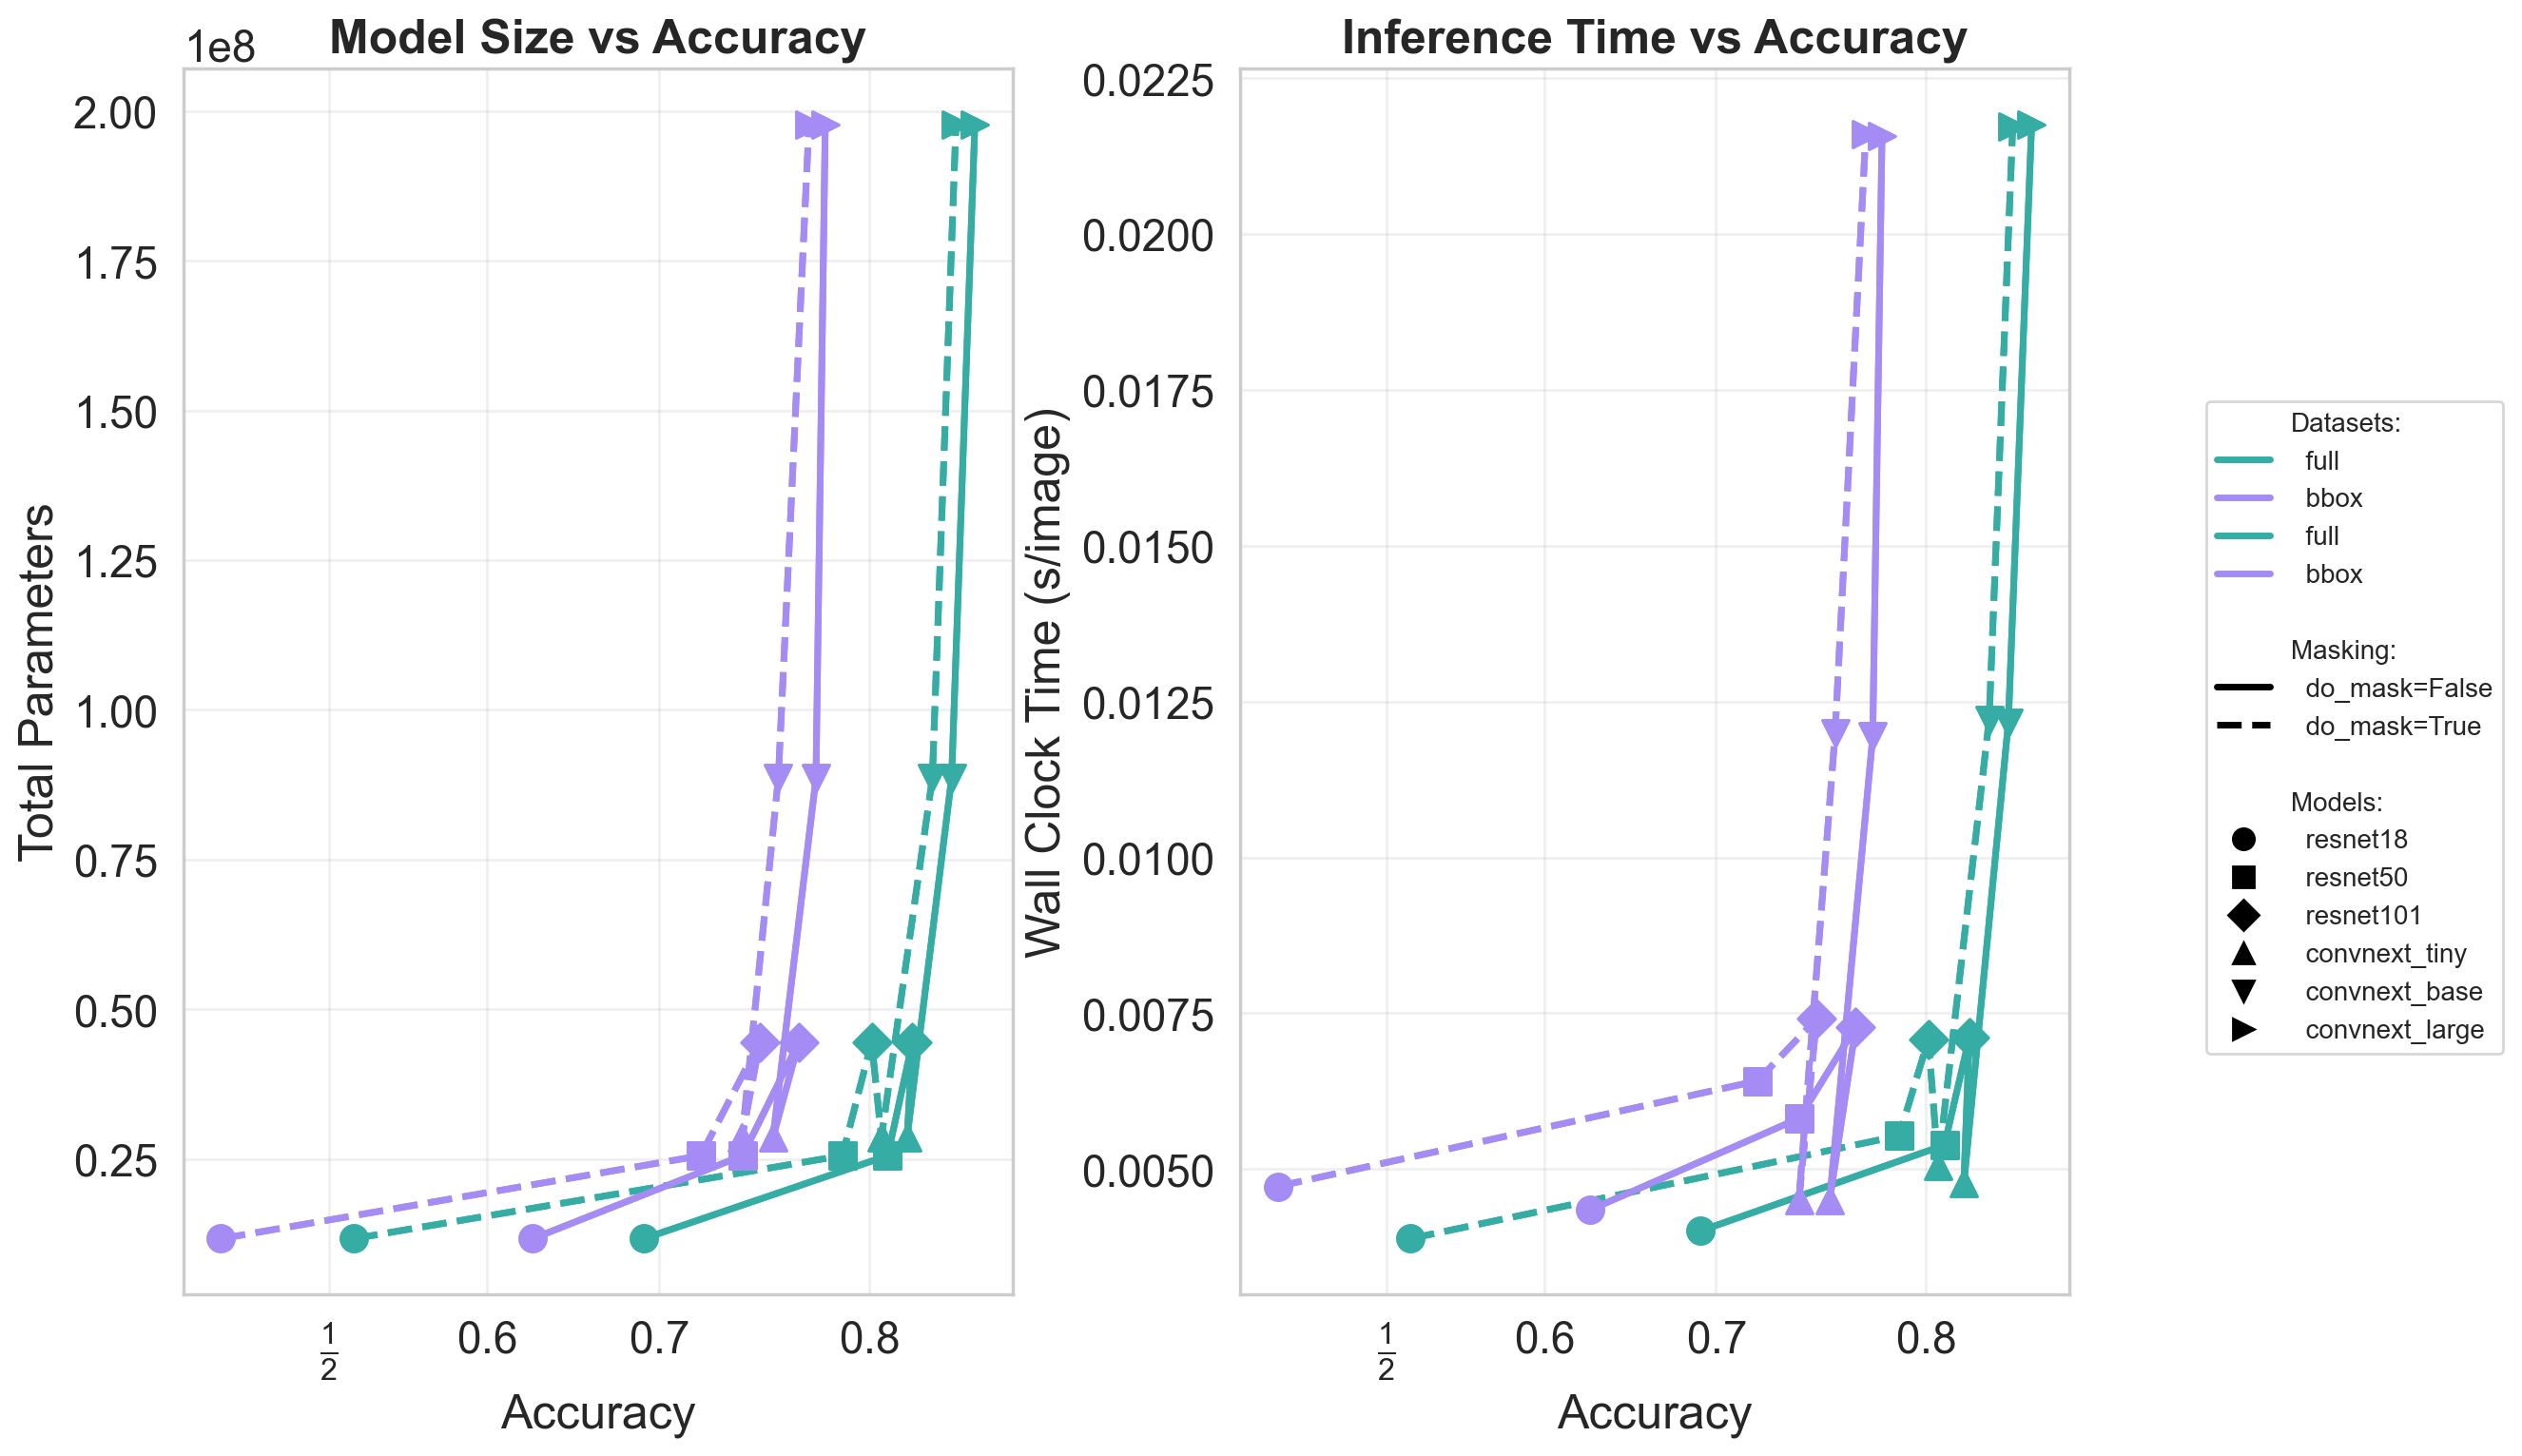

In [8]:
combined_all_results = fovea.pd.concat([results13, results14], ignore_index=True)
combined_model_names = fovea.all_model_names
combined_model_names.extend(fovea.all_cn_model_names)
combined_all_datasets = fovea.all_datasets
combined_all_datasets.extend(fovea.all_datasets)

fig, axes = fovea.plot_model_comparison(combined_all_results, combined_model_names, combined_all_datasets, do_masks=[True, False], 
                                        figures_folder=args.figures_folder)
